In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [3]:
import sys
sys.path.append(os.path.abspath('../'))
import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [4]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [5]:
from glob import glob
debug=True
target_fbi_weight = glob("../../weights/2*F08*F32*")
target_fbi_weight = list(filter(lambda x : "l1_on" not in x,target_fbi_weight))
for weight in target_fbi_weight:
    print(weight)    

../../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w


In [6]:
def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    dataset_version = 'v1' if 'with_SET01020304' in fbi_weight_dir else 'v2'
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("l1_on_img_gradient_")[1].split("_")[0]
        dataset_version += f"_l1_{lambda_val}" # f"_l1_on_img_gradient_{lambda_val}
    return target_x,target_y, dataset_version

In [7]:
fbi_weight_dir = target_fbi_weight[0]
print(fbi_weight_dir)


target_x,target_y, dataset_version = parsing_weight_name(fbi_weight_dir)

# if target_y not in ['F08','F16']:
#     continue
print("======",target_x,"vs",target_y,dataset_version," ======")
if debug is True:
    print(fbi_weight_dir)
    # print(median_filter_input,"median_filter_input")
model_name = f"RN2N_{target_x}-{target_y}_{dataset_version}"

    # folder_name += "_median_filter_input_but_not_used_at_inference"
print("model_name : ",model_name)



model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)



../../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
====== F08 vs F32 v2  ======
../../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F08_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
model_name :  RN2N_F08-F32_v2


In [8]:
import h5py
img_dict = {}
with h5py.File("../../data/test_Samsung_SNU_patches_SET050607080910_divided_by_fnum_setnum.hdf5") as f:
    for key in f.keys():
        #print(key)
        img_dict[key] = {} # f[key]
        for subkey in f[key].keys():
            img_dict[key][subkey] = np.array(f[key][subkey])
    
noisy_images = img_dict['SET06']['F08']


In [9]:
# with h5py.File("../../data/test_Samsung_SNU_patches_SET01020304_divided_by_fnum_setnum.hdf5") as f:
#     noisy_images = np.array(f['SET01']['F08'])


In [10]:
noisy_images.shape

(480, 256, 256)

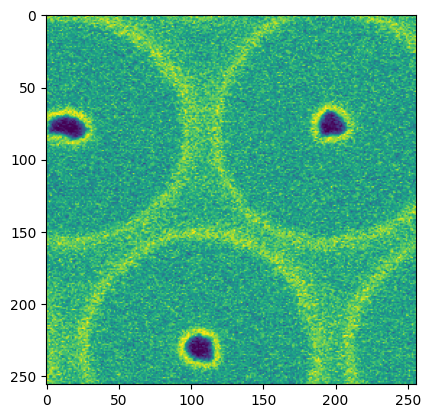

In [11]:
plt.imshow(noisy_images[0])

In [12]:
img = noisy_images[0]
img = np.expand_dims(img,axis=0)
img = np.expand_dims(img,axis=0)
denoised_img = model.eval(img)[0][0]

In [13]:
img.shape, denoised_img.shape

((1, 1, 256, 256), (256, 256))

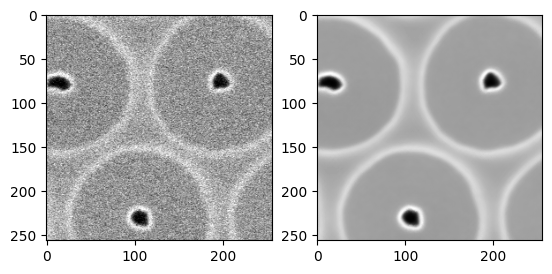

In [14]:
plt.subplot(121)
plt.imshow(img[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(denoised_img,cmap='gray')

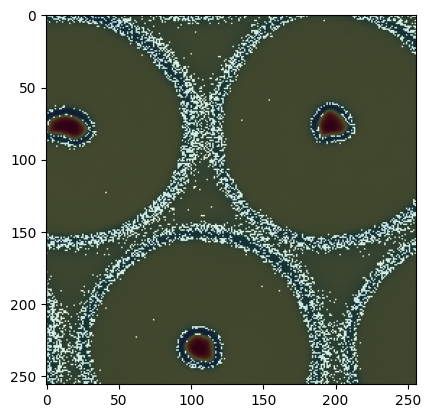

In [19]:

img = img_dict['SET06']['F64'][0]

img_edge = img.copy()
min_val = 0.77
max_val = 0.83
img_edge[img_edge<min_val] = 0 
img_edge[img_edge>max_val] = 0 
img_edge[img_edge !=0] = 1
plt.imshow(img_edge, cmap='gray')
plt.imshow(denoised_img,cmap='Spectral',alpha=0.3)

In [123]:
epoch9 = cv2.imread("./media_images_eval_F01-F04_SET10_F01_epoch9.png", cv2.IMREAD_GRAYSCALE)
epoch10 = cv2.imread("./media_images_eval_F01-F04_SET10_F01_epoch10.png",cv2.IMREAD_GRAYSCALE)

SET06 1st image


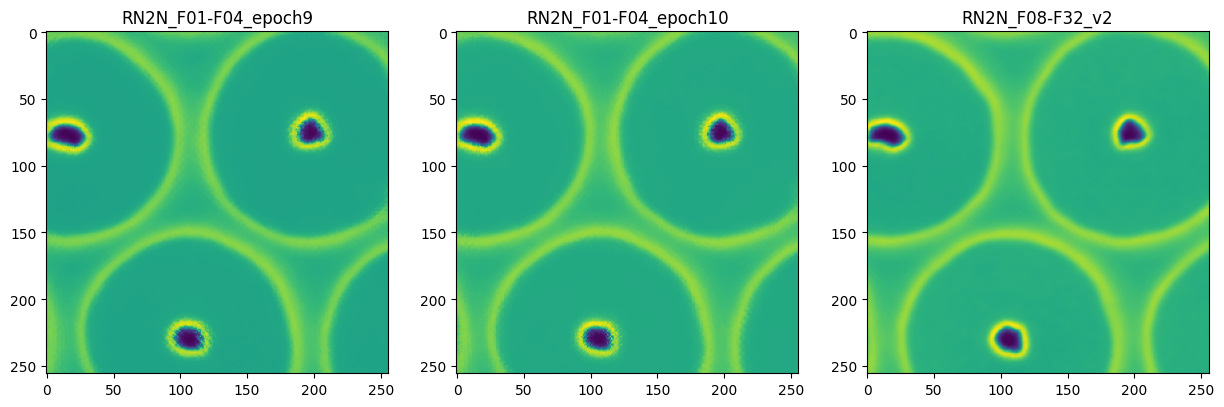

In [124]:
print("SET06 1st image")
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("RN2N_F01-F04_epoch9")
plt.imshow(epoch9)
plt.subplot(132)
plt.title("RN2N_F01-F04_epoch10")
plt.imshow(epoch10)
plt.subplot(133)
plt.title(model_name)
plt.imshow(denoised_img)

SET06 1st image


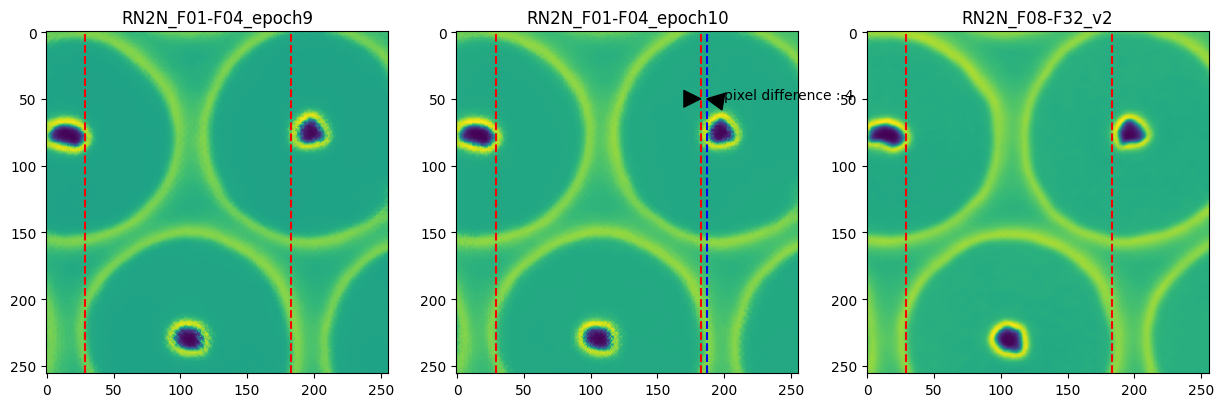

In [125]:
print("SET06 1st image")
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("RN2N_F01-F04_epoch9")
plt.imshow(epoch9)
plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.subplot(132)
plt.title("RN2N_F01-F04_epoch10")
plt.imshow(epoch10)
plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')
plt.axvline(x=187, color='b', linestyle='--')
plt.annotate('pixel difference : 4', xy=(187, 50), xytext=(200, 50), color='black', fontsize=10,
             arrowprops=dict(facecolor='black', shrink=0.005))

plt.annotate('', xy=(183, 50), xytext=(170, 50), color='black', fontsize=10,
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.subplot(133)
plt.title(model_name)
plt.imshow(denoised_img)
plt.axvline(x=29, color='r', linestyle='--')
plt.axvline(x=183, color='r', linestyle='--')

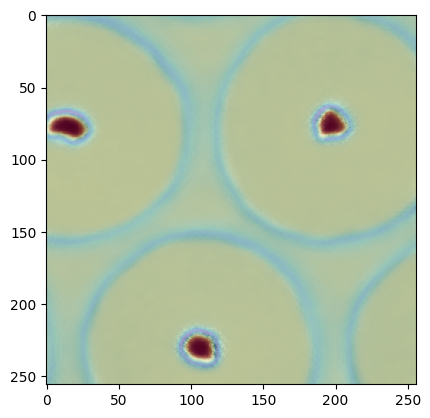

In [111]:
plt.imshow(epoch9,cmap='gray')
plt.imshow(denoised_img,alpha=0.5,cmap='Spectral')

Lossy conversion from float32 to uint8. Range [-0.0032074851915240288, 0.9877159595489502]. Convert image to uint8 prior to saving to suppress this warning.


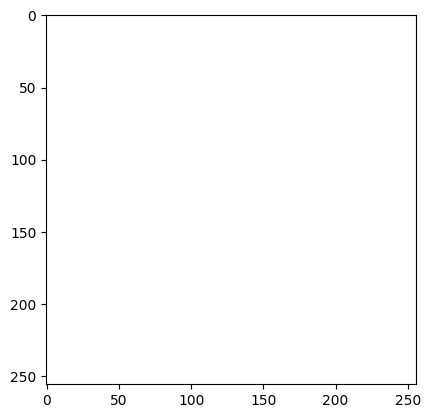

In [135]:
from celluloid import Camera # getting the camera
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
frames = []
fig, ax = plt.subplots() # make it bigger
camera = Camera(fig)# the camera gets our figure
ax.imshow(epoch9,cmap='gray')
frames.append(epoch9)
camera.snap()
# ax.imshow(epoch10,cmap='gray')
# camera.snap()
ax.imshow(denoised_img,cmap='gray')
frames.append(denoised_img)
camera.snap()  
animation = camera.animate()
imageio.mimsave("./epoch9_vs_F08-F32.gif", frames, fps=2.5)
HTML(animation.to_html5_video())

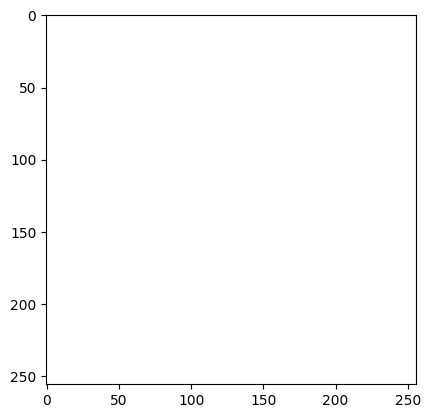

In [129]:
fig, ax = plt.subplots() # make it bigger
camera = Camera(fig)# the camera gets our figure
ax.imshow(epoch9,cmap='gray')
camera.snap()
ax.imshow(epoch10,cmap='gray')
camera.snap()  
animation = camera.animate()
HTML(animation.to_html5_video())